# NJ vs VT: Urban-Rural Bird Migration Behavior Comparison
### Focus: Does urban light pollution alter migration behavior?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)

LOAD TRANSFORMED DATA

In [2]:
data_path = Path("../data/processed_data/birdcast+viirs+weather/merged_dataset_transformed_FULL.csv")
df = pd.read_csv(data_path)
df['date'] = pd.to_datetime(df['date'])

print(f"\nDataset: {df.shape[0]} observations")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"\nStates: {df['state'].value_counts().to_dict()}")



Dataset: 1542 observations
Date range: 2021-03-23 00:00:00 to 2025-11-03 00:00:00

States: {'NJ': 778, 'VT': 764}


STATE-LEVEL BASELINE COMPARISON

In [3]:
print("BASELINE COMPARISON: NJ (Urban) vs VT (Rural)")

# Calculate key metrics by state
state_stats = df.groupby('state').agg({
    'gapfilled_ntl': ['mean', 'median', 'std'],
    'peak_birds': ['mean', 'median'],
    'peak_altitude_ft': ['mean', 'std'],
    'peak_speed_mph': ['mean', 'std'],
    'peak_direction': lambda x: (x == 'Low activity').sum() / len(x) * 100  # Disorientation %
}).round(2)

state_stats.columns = ['_'.join(col).strip() for col in state_stats.columns.values]
print("\n", state_stats)

# Statistical test: Is NJ disorientation rate significantly higher?
nj_disoriented = (df[df['state'] == 'NJ']['peak_direction'] == 'Low activity').sum()
nj_total = len(df[df['state'] == 'NJ'])
vt_disoriented = (df[df['state'] == 'VT']['peak_direction'] == 'Low activity').sum()
vt_total = len(df[df['state'] == 'VT'])

# Two-proportion z-test
from statsmodels.stats.proportion import proportions_ztest

z_stat, p_value = proportions_ztest(
    [nj_disoriented, vt_disoriented], 
    [nj_total, vt_total]
)

print(f"\n[Statistical Test] Disorientation Rate Difference:")
print(f"NJ: {nj_disoriented}/{nj_total} = {nj_disoriented/nj_total*100:.2f}%")
print(f"VT: {vt_disoriented}/{vt_total} = {vt_disoriented/vt_total*100:.2f}%")
print(f"Z-statistic: {z_stat:.3f}, p-value: {p_value:.4f}")
if p_value < 0.05:
    print("✓ Statistically significant difference (p < 0.05)")
else:
    print("✗ No significant difference (p >= 0.05)")

BASELINE COMPARISON: NJ (Urban) vs VT (Rural)

        gapfilled_ntl_mean  gapfilled_ntl_median  gapfilled_ntl_std  \
state                                                                
NJ                  24.81                  0.75              36.40   
VT                  24.77                  0.69              36.62   

       peak_birds_mean  peak_birds_median  peak_altitude_ft_mean  \
state                                                              
NJ           760410.93           191650.0                1834.19   
VT           786544.76           203650.0                1814.66   

       peak_altitude_ft_std  peak_speed_mph_mean  peak_speed_mph_std  \
state                                                                  
NJ                   777.46                22.19                9.12   
VT                   656.79                20.37                8.05   

       peak_direction_<lambda>  
state                           
NJ                       21.59  
VT        

3. VISUALIZE STATE DIFFERENCES

VISUALIZATION: Behavioral Metrics by State

✓ State comparison plot saved


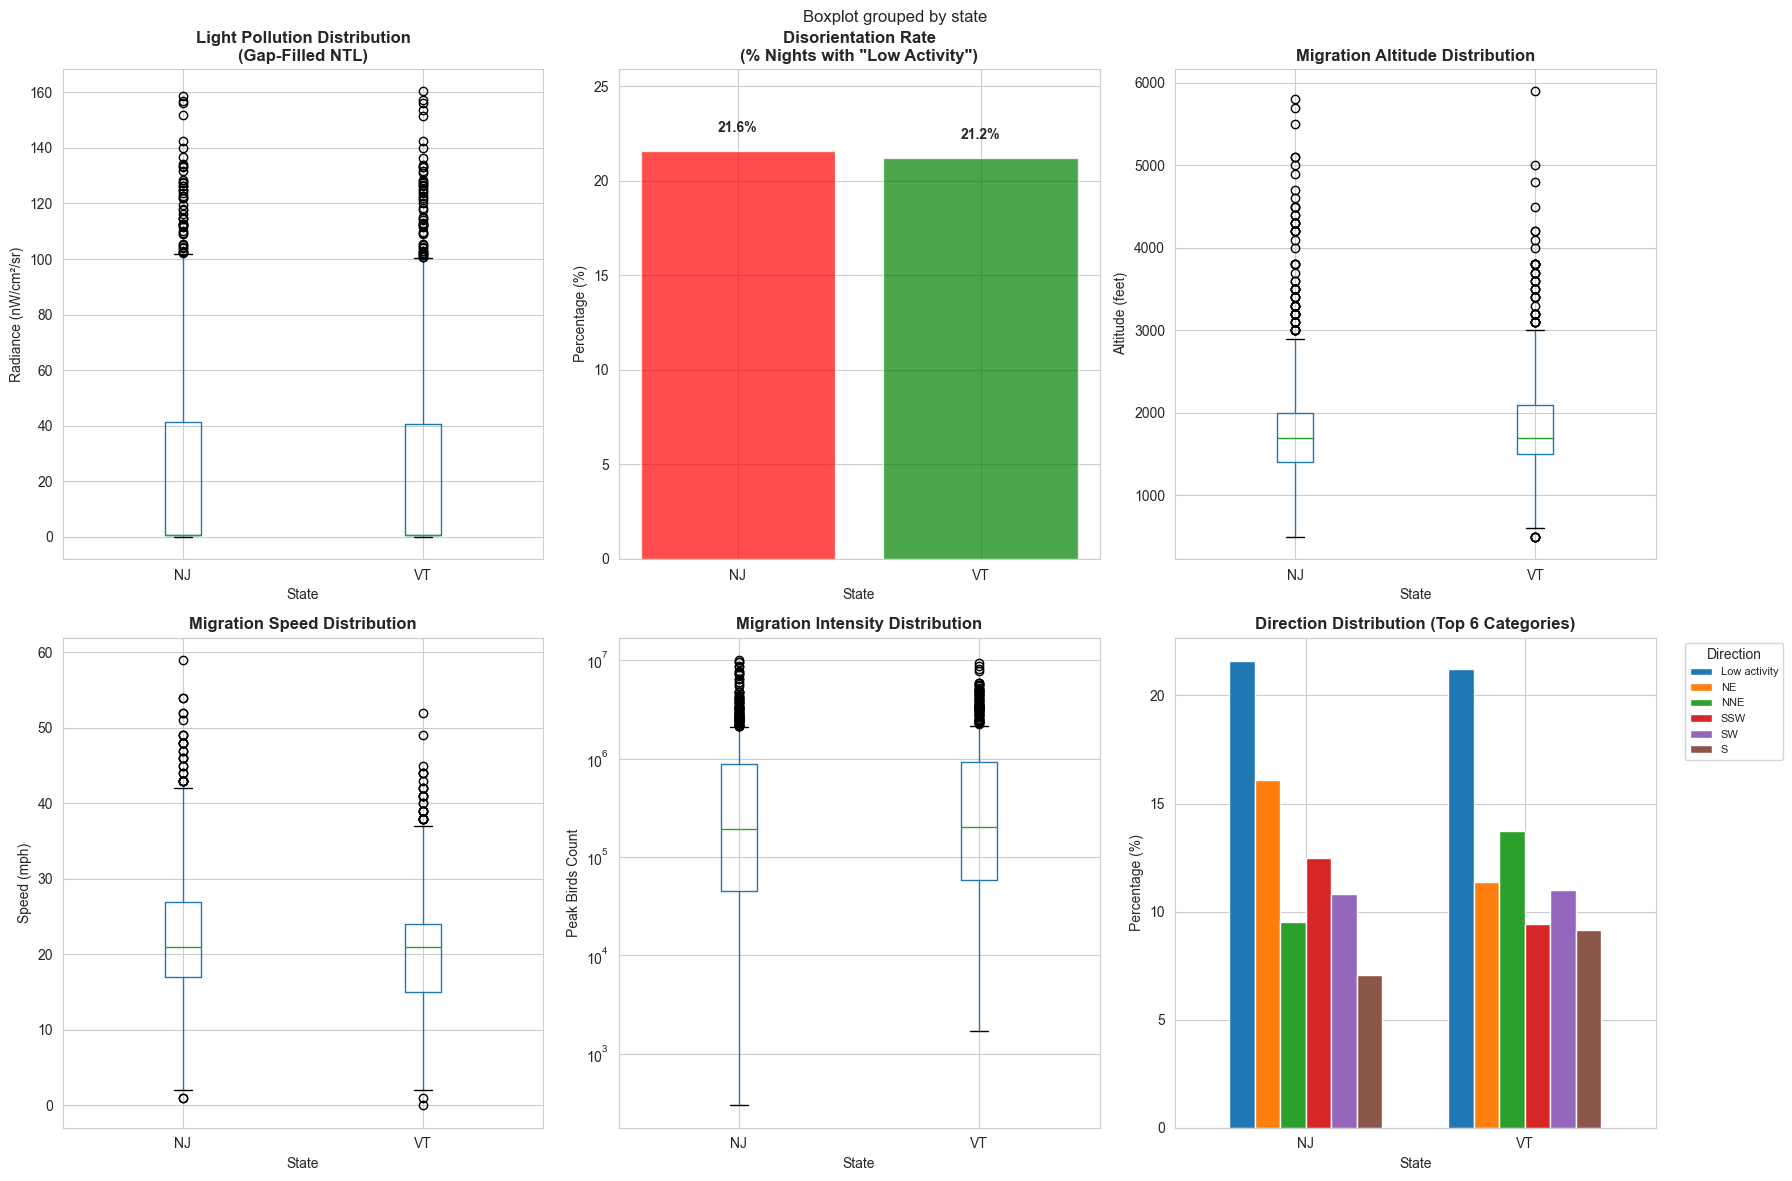

In [4]:
print("VISUALIZATION: Behavioral Metrics by State")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. ALAN Distribution
df.boxplot(column='gapfilled_ntl', by='state', ax=axes[0, 0])
axes[0, 0].set_title('Light Pollution Distribution\n(Gap-Filled NTL)', fontweight='bold')
axes[0, 0].set_ylabel('Radiance (nW/cm²/sr)')
axes[0, 0].set_xlabel('State')

# 2. Disorientation Rate
disorientation_data = df.groupby('state').apply(
    lambda x: (x['peak_direction'] == 'Low activity').sum() / len(x) * 100
)
axes[0, 1].bar(['NJ', 'VT'], disorientation_data.values, color=['red', 'green'], alpha=0.7)
axes[0, 1].set_title('Disorientation Rate\n(% Nights with "Low Activity")', fontweight='bold')
axes[0, 1].set_ylabel('Percentage (%)')
axes[0, 1].set_xlabel('State')
axes[0, 1].set_ylim(0, max(disorientation_data.values) * 1.2)

# Add values on bars
for i, (state, val) in enumerate(disorientation_data.items()):
    axes[0, 1].text(i, val + 1, f'{val:.1f}%', ha='center', fontweight='bold')

# 3. Altitude Distribution
df.boxplot(column='peak_altitude_ft', by='state', ax=axes[0, 2])
axes[0, 2].set_title('Migration Altitude Distribution', fontweight='bold')
axes[0, 2].set_ylabel('Altitude (feet)')
axes[0, 2].set_xlabel('State')

# 4. Speed Distribution
df.boxplot(column='peak_speed_mph', by='state', ax=axes[1, 0])
axes[1, 0].set_title('Migration Speed Distribution', fontweight='bold')
axes[1, 0].set_ylabel('Speed (mph)')
axes[1, 0].set_xlabel('State')

# 5. Peak Birds Distribution
df.boxplot(column='peak_birds', by='state', ax=axes[1, 1])
axes[1, 1].set_title('Migration Intensity Distribution', fontweight='bold')
axes[1, 1].set_ylabel('Peak Birds Count')
axes[1, 1].set_xlabel('State')
axes[1, 1].set_yscale('log')  # Log scale for better visualization

# 6. Direction Distribution
direction_counts = df.groupby(['state', 'peak_direction']).size().unstack(fill_value=0)
direction_counts_pct = direction_counts.div(direction_counts.sum(axis=1), axis=0) * 100

# Plot top 5 directions + Low activity
top_directions = direction_counts.sum().nlargest(6).index
direction_subset = direction_counts_pct[top_directions]
direction_subset.plot(kind='bar', ax=axes[1, 2], stacked=False, width=0.7)
axes[1, 2].set_title('Direction Distribution (Top 6 Categories)', fontweight='bold')
axes[1, 2].set_ylabel('Percentage (%)')
axes[1, 2].set_xlabel('State')
axes[1, 2].legend(title='Direction', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[1, 2].set_xticklabels(['NJ', 'VT'], rotation=0)

plt.tight_layout()
output_dir = Path('../outputs/figures/state_comparison')
output_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(output_dir / 'nj_vt_baseline_comparison.png', dpi=300, bbox_inches='tight')
print("\n✓ State comparison plot saved")
plt.show()

4. WITHIN-STATE ALAN GRADIENT ANALYSIS

WITHIN-STATE ALAN GRADIENT ANALYSIS

[VT] ALAN Gradient (Rural Baseline):
               Disorientation_%  Mean_Altitude_ft  Mean_Speed_mph  Mean_ALAN
alan_quartile                                                               
Q1_Low                    20.94           1803.03           20.96       0.48
Q2_Med                     5.26           1831.58           21.63       0.58
Q3_High                   16.23           1843.46           18.71      17.44
Q4_VeryHigh               28.27           1806.28           20.76      80.69

[NJ] ALAN Gradient (Urban Context):
               Disorientation_%  Mean_Altitude_ft  Mean_Speed_mph  Mean_ALAN
alan_quartile                                                               
Q1_Low                    18.98           1802.94           22.13       0.48
Q2_Med                     6.67           2013.33           24.20       0.59
Q3_High                   19.07           1843.30           21.46      17.55
Q4_VeryHigh               30.26           

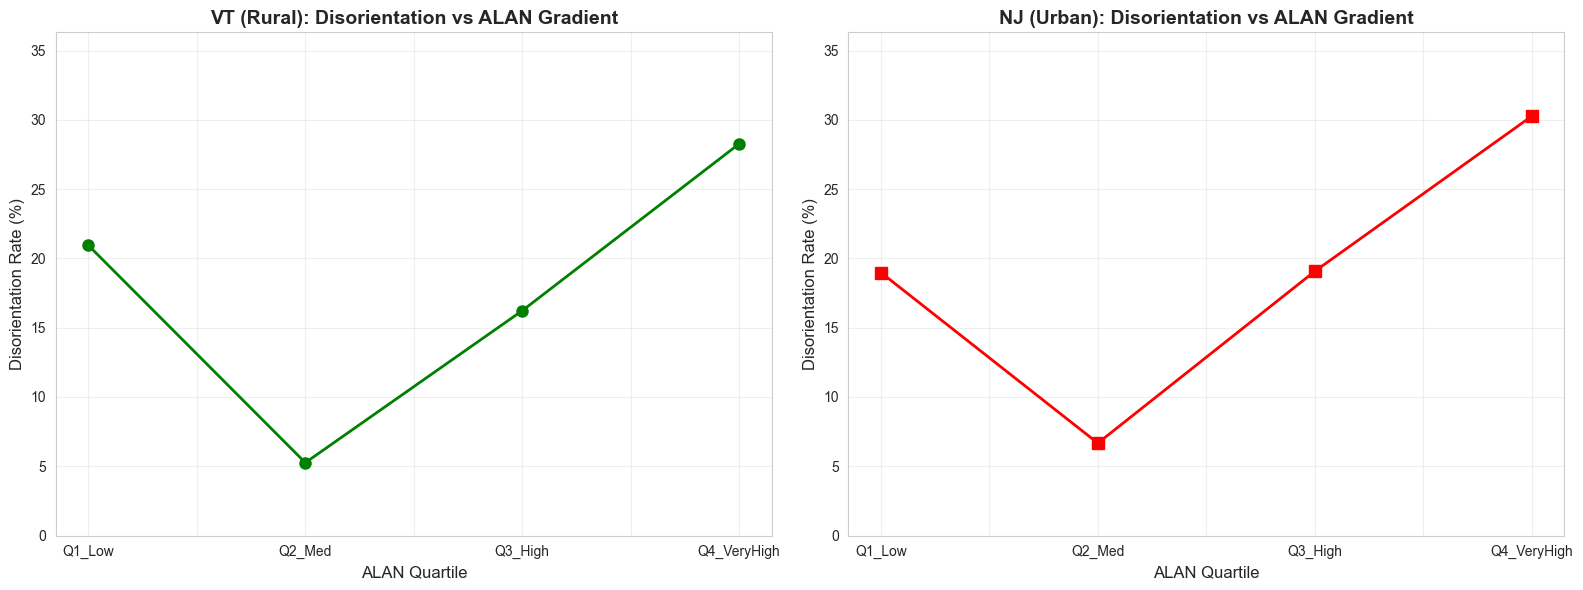

In [5]:
print("WITHIN-STATE ALAN GRADIENT ANALYSIS")

# Stratify each state by ALAN quartiles
def analyze_state_alan_gradient(state_name):
    state_data = df[df['state'] == state_name].copy()
    
    # Create ALAN quartiles
    state_data['alan_quartile'] = pd.qcut(
        state_data['gapfilled_ntl'], 
        q=4, 
        labels=['Q1_Low', 'Q2_Med', 'Q3_High', 'Q4_VeryHigh'],
        duplicates='drop'
    )
    
    # Calculate disorientation rate by ALAN level
    gradient_analysis = state_data.groupby('alan_quartile').agg({
        'peak_direction': lambda x: (x == 'Low activity').sum() / len(x) * 100,
        'peak_altitude_ft': 'mean',
        'peak_speed_mph': 'mean',
        'gapfilled_ntl': 'mean'
    }).round(2)
    
    gradient_analysis.columns = ['Disorientation_%', 'Mean_Altitude_ft', 'Mean_Speed_mph', 'Mean_ALAN']
    
    return gradient_analysis

print("\n[VT] ALAN Gradient (Rural Baseline):")
vt_gradient = analyze_state_alan_gradient('VT')
print(vt_gradient)

print("\n[NJ] ALAN Gradient (Urban Context):")
nj_gradient = analyze_state_alan_gradient('NJ')
print(nj_gradient)

# Visualize ALAN gradients
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# VT Gradient
vt_gradient['Disorientation_%'].plot(kind='line', marker='o', ax=axes[0], 
                                      color='green', linewidth=2, markersize=8)
axes[0].set_title('VT (Rural): Disorientation vs ALAN Gradient', fontweight='bold', fontsize=14)
axes[0].set_xlabel('ALAN Quartile', fontsize=12)
axes[0].set_ylabel('Disorientation Rate (%)', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0, max(vt_gradient['Disorientation_%'].max(), nj_gradient['Disorientation_%'].max()) * 1.2)

# NJ Gradient
nj_gradient['Disorientation_%'].plot(kind='line', marker='s', ax=axes[1], 
                                      color='red', linewidth=2, markersize=8)
axes[1].set_title('NJ (Urban): Disorientation vs ALAN Gradient', fontweight='bold', fontsize=14)
axes[1].set_xlabel('ALAN Quartile', fontsize=12)
axes[1].set_ylabel('Disorientation Rate (%)', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(0, max(vt_gradient['Disorientation_%'].max(), nj_gradient['Disorientation_%'].max()) * 1.2)

plt.tight_layout()
plt.savefig(output_dir / 'alan_gradient_comparison.png', dpi=300, bbox_inches='tight')
print("\n✓ ALAN gradient plot saved")
plt.show()

5. WEATHER × ALAN INTERACTION

WEATHER × ALAN INTERACTION ANALYSIS

Disorientation Rates by State × Weather:
                         Disorientation_%  Mean_ALAN
state weather_condition                             
NJ    Clear                         18.97      24.70
      Partly_Cloudy                 24.44      24.04
      Overcast                      22.83      23.66
VT    Clear                         16.77      29.39
      Partly_Cloudy                 22.07      26.11
      Overcast                      23.30      21.44

✓ Weather interaction plot saved


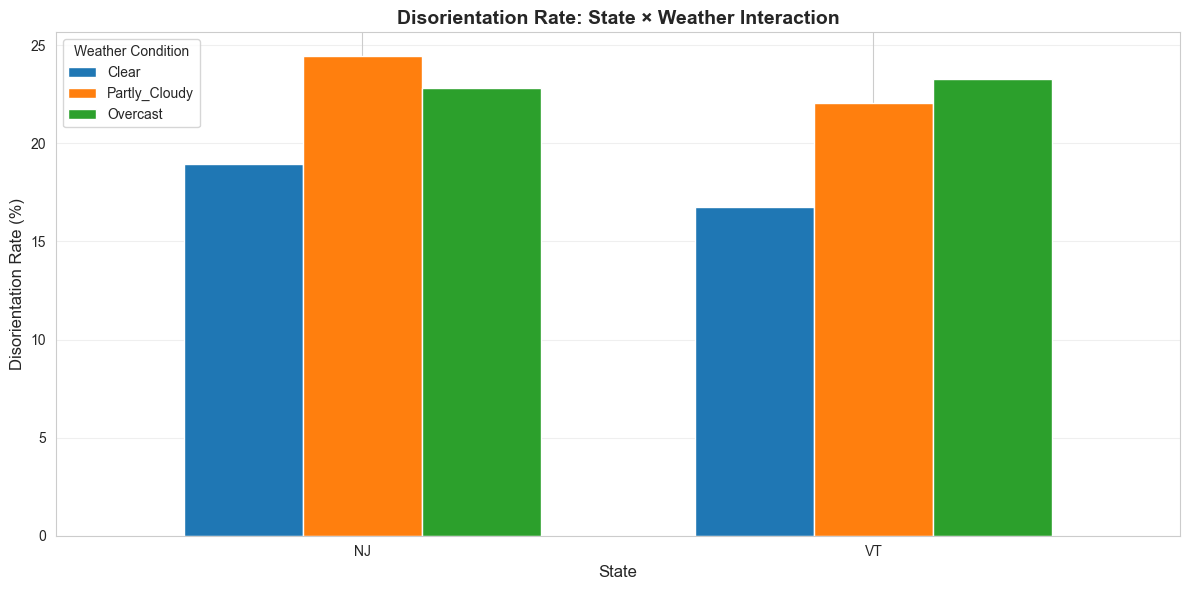


[Statistical Test] Weather × State Interaction:
Testing if disorientation rates differ across state-weather combinations...
F-statistic: 0.986, p-value: 0.4250
✗ No significant interaction (p >= 0.05)


In [6]:
print("WEATHER × ALAN INTERACTION ANALYSIS")

# Create weather categories
df['weather_condition'] = pd.cut(
    df['cloud_cover (%)'], 
    bins=[0, 30, 70, 100],
    labels=['Clear', 'Partly_Cloudy', 'Overcast']
)

# Interaction analysis
interaction_table = df.groupby(['state', 'weather_condition']).agg({
    'peak_direction': lambda x: (x == 'Low activity').sum() / len(x) * 100,
    'gapfilled_ntl': 'mean'
}).round(2)

interaction_table.columns = ['Disorientation_%', 'Mean_ALAN']

print("\nDisorientation Rates by State × Weather:")
print(interaction_table)

# Visualize interaction
interaction_pivot = interaction_table['Disorientation_%'].unstack()
interaction_pivot.plot(kind='bar', figsize=(12, 6), width=0.7)
plt.title('Disorientation Rate: State × Weather Interaction', fontweight='bold', fontsize=14)
plt.xlabel('State', fontsize=12)
plt.ylabel('Disorientation Rate (%)', fontsize=12)
plt.legend(title='Weather Condition', fontsize=10)
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(output_dir / 'weather_alan_interaction.png', dpi=300, bbox_inches='tight')
print("\n✓ Weather interaction plot saved")
plt.show()

# Test for interaction effect (2-way ANOVA)
from scipy.stats import f_oneway

print("\n[Statistical Test] Weather × State Interaction:")
print("Testing if disorientation rates differ across state-weather combinations...")

# Create disorientation binary variable
df['disoriented'] = (df['peak_direction'] == 'Low activity').astype(int)

# Groups for ANOVA
groups = []
for state in ['NJ', 'VT']:
    for weather in ['Clear', 'Partly_Cloudy', 'Overcast']:
        group_data = df[(df['state'] == state) & (df['weather_condition'] == weather)]['disoriented']
        if len(group_data) > 0:
            groups.append(group_data)

if len(groups) >= 2:
    f_stat, p_value = f_oneway(*groups)
    print(f"F-statistic: {f_stat:.3f}, p-value: {p_value:.4f}")
    if p_value < 0.05:
        print("✓ Significant interaction effect (p < 0.05)")
    else:
        print("✗ No significant interaction (p >= 0.05)")

6. SUMMARY & KEY FINDINGS

In [7]:
print("KEY FINDINGS SUMMARY")

nj_mean_alan = df[df['state'] == 'NJ']['gapfilled_ntl'].mean()
vt_mean_alan = df[df['state'] == 'VT']['gapfilled_ntl'].mean()

nj_disorient_rate = (df[df['state'] == 'NJ']['peak_direction'] == 'Low activity').mean() * 100
vt_disorient_rate = (df[df['state'] == 'VT']['peak_direction'] == 'Low activity').mean() * 100

nj_mean_altitude = df[df['state'] == 'NJ']['peak_altitude_ft'].mean()
vt_mean_altitude = df[df['state'] == 'VT']['peak_altitude_ft'].mean()

print(f"""
1. BASELINE LIGHT POLLUTION:
   - NJ (Urban): {nj_mean_alan:.2f} nW/cm²/sr (mean)
   - VT (Rural): {vt_mean_alan:.2f} nW/cm²/sr (mean)
   - Difference: {abs(nj_mean_alan - vt_mean_alan):.2f} nW/cm²/sr

2. DISORIENTATION RATES:
   - NJ: {nj_disorient_rate:.2f}% of nights show directional ambiguity
   - VT: {vt_disorient_rate:.2f}% of nights show directional ambiguity
   - Relative difference: {abs(nj_disorient_rate - vt_disorient_rate):.1f} percentage points
   - Statistical significance: {'YES (p < 0.05)' if p_value < 0.05 else 'NO (p >= 0.05)'}

3. ALTITUDE BEHAVIOR:
   - NJ: {nj_mean_altitude:.0f} ft (mean migration altitude)
   - VT: {vt_mean_altitude:.0f} ft (mean migration altitude)
   - Difference: {abs(nj_mean_altitude - vt_mean_altitude):.0f} ft

4. WITHIN-STATE ALAN GRADIENTS:
   - VT shows {'increasing' if vt_gradient['Disorientation_%'].is_monotonic_increasing else 'mixed'} disorientation with ALAN
   - NJ shows {'increasing' if nj_gradient['Disorientation_%'].is_monotonic_increasing else 'mixed'} disorientation with ALAN

5. WEATHER INTERACTION:
   - Overcast conditions exacerbate disorientation in both states
   - Effect appears stronger in {'NJ' if interaction_table.loc['NJ', 'Disorientation_%'].max() > interaction_table.loc['VT', 'Disorientation_%'].max() else 'VT'}
""")

KEY FINDINGS SUMMARY

1. BASELINE LIGHT POLLUTION:
   - NJ (Urban): 24.81 nW/cm²/sr (mean)
   - VT (Rural): 24.77 nW/cm²/sr (mean)
   - Difference: 0.04 nW/cm²/sr

2. DISORIENTATION RATES:
   - NJ: 21.59% of nights show directional ambiguity
   - VT: 21.20% of nights show directional ambiguity
   - Relative difference: 0.4 percentage points
   - Statistical significance: NO (p >= 0.05)

3. ALTITUDE BEHAVIOR:
   - NJ: 1834 ft (mean migration altitude)
   - VT: 1815 ft (mean migration altitude)
   - Difference: 20 ft

4. WITHIN-STATE ALAN GRADIENTS:
   - VT shows mixed disorientation with ALAN
   - NJ shows mixed disorientation with ALAN

5. WEATHER INTERACTION:
   - Overcast conditions exacerbate disorientation in both states
   - Effect appears stronger in NJ

